# Algorithmic Trading Model for Exponential Moving Average Crossover Take 4
### David Lowe
### May 28, 2020

SUMMARY: The purpose of this project is to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model uses the 20-day and 50-day exponential moving averages to generate trading signals. When the fast moving-average curve crosses above the slow moving-average curve, the strategy goes long (buys) on the stock. When the opposite occurs, we will exit the position. We apply the analysis on the GOOG stock for the three years of 2017-01-01 thru 2019-12-31.

In iteration Take1, we constructed and tested a trading strategy using the daily stock data from Yahoo! Finance with an initial investment pool of 1,500 USD.

In iteration Take2, we constructed and tested a trading strategy using the daily stock data from Alpha Vantage with an initial investment pool of 1,500 USD. We also leveraged the technical indicators available from Alpha Vantage.

In iteration Take3, we constructed and tested a trading strategy using the daily stock data from IEX Cloud with an initial investment pool of 1,500 USD. We also leveraged the technical indicators available from IEX Cloud.

In this Take4 iteration, we will construct and test a trading strategy using the daily stock data from Quandl with an initial investment pool of 1,500 USD.

ANALYSIS: In iteration Take1, the trading strategy returned 27.94%. In the meantime, the long-only approach achieved an accumulated return of 37.21%.

In iteration Take2, the trading strategy returned 27.94%. In the meantime, the long-only approach achieved an accumulated return of 37.21%.

In iteration Take3, the trading strategy returned 27.94%. In the meantime, the long-only approach achieved an accumulated return of 37.21%.

In this Take4 iteration, the trading strategy returned 27.94%. In the meantime, the long-only approach achieved an accumulated return of 37.21%.

CONCLUSION: For this period, the trading strategy did not outperform the more straightforward long-only approach. We should consider more modeling with different methods for this stock. However, we were able to successfully use the data sources from Quandl to perform our modeling.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Develop Strategy and Train Model
4. Back-test Model
5. Evaluate Performance

## Task 1. Prepare Environment

In [1]:
import os
import sys
import smtplib
import numpy as np
import pandas as pd
import requests
import json
from email.message import EmailMessage
import matplotlib.pyplot as plt
from datetime import datetime
# import pandas_datareader.data as pdr

In [2]:
# Define the function for sending the status notification emails
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if (sender is None) or (receiver is None) or (gateway is None) or (smtpuser is None) or (password is None):
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Algorithmic Trading Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [3]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Configure the plotting style
plt.style.use('seaborn')

In [4]:
if notifyStatus: email_notify("Task 1. Prepare Environment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [5]:
stock_symbol = 'GOOG'
initial_capital = 1500

stock_start_date = datetime(2016, 10, 1) # Need more pricing data to calculate moving averages
model_start_date = datetime(2017, 1, 1)
print("Starting date for the model:", model_start_date)
# end_date = datetime.now()
model_end_date = datetime(2020, 1, 1)
print("Ending date for the model:", model_end_date)

# Specify the parameters for the trading strategy
fast_ma = 20
slow_ma = 50

Starting date for the model: 2017-01-01 00:00:00
Ending date for the model: 2020-01-01 00:00:00


In [6]:
if notifyStatus: email_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2. Acquire and Pre-Process Data

In [7]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [8]:
# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [9]:
start_date_string = stock_start_date.strftime('%Y-%m-%d')
end_date_string = model_end_date.strftime('%Y-%m-%d')

quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, stock_symbol, quandl_key)

In [10]:
response = requests.get(quandl_url)
quandl_dict = json.loads(response.text)
stock_quandl = pd.DataFrame(quandl_dict['datatable']['data'])
print(len(stock_quandl), 'data points retrieved from the API call.')
if verbose: print(quandl_dict)

817 data points retrieved from the API call.


In [11]:
stock_quandl.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_quandl.set_index('date', inplace=True)
stock_quandl.index = pd.to_datetime(stock_quandl.date)
stock_quandl = stock_quandl.sort_index(ascending = True)
stock_quandl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 817 entries, 2016-10-03 to 2019-12-31
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       817 non-null    object 
 1   date         817 non-null    object 
 2   open         817 non-null    float64
 3   high         817 non-null    float64
 4   low          817 non-null    float64
 5   close        817 non-null    float64
 6   volume       817 non-null    float64
 7   dividend     817 non-null    float64
 8   closeunadj   817 non-null    float64
 9   lastupdated  817 non-null    object 
dtypes: float64(7), object(3)
memory usage: 70.2+ KB


In [12]:
stock_quandl.head()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2016-10-03,GOOG,2016-10-03,774.25,776.065,769.50,772.56,1278821.0,0.0,772.56,2018-06-13
2016-10-04,GOOG,2016-10-04,776.03,778.710,772.89,776.43,1201350.0,0.0,776.43,2018-06-13
2016-10-05,GOOG,2016-10-05,779.31,782.070,775.65,776.47,1461151.0,0.0,776.47,2018-06-13
2016-10-06,GOOG,2016-10-06,779.00,780.480,775.54,776.86,1070692.0,0.0,776.86,2018-06-13
2016-10-07,GOOG,2016-10-07,779.66,779.660,770.75,775.08,933158.0,0.0,775.08,2018-06-13


In [13]:
stock_quandl.tail()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2019-12-24,GOOG,2019-12-24,1348.50,1350.26,1342.78,1343.56,347518.0,0.0,1343.56,2020-05-01
2019-12-26,GOOG,2019-12-26,1346.17,1361.33,1344.47,1360.40,667754.0,0.0,1360.40,2020-05-01
2019-12-27,GOOG,2019-12-27,1362.99,1364.53,1349.31,1351.89,1038718.0,0.0,1351.89,2020-05-01
2019-12-30,GOOG,2019-12-30,1350.00,1353.00,1334.02,1336.14,1051323.0,0.0,1336.14,2020-05-01
2019-12-31,GOOG,2019-12-31,1330.11,1338.00,1329.09,1337.02,962468.0,0.0,1337.02,2020-05-01


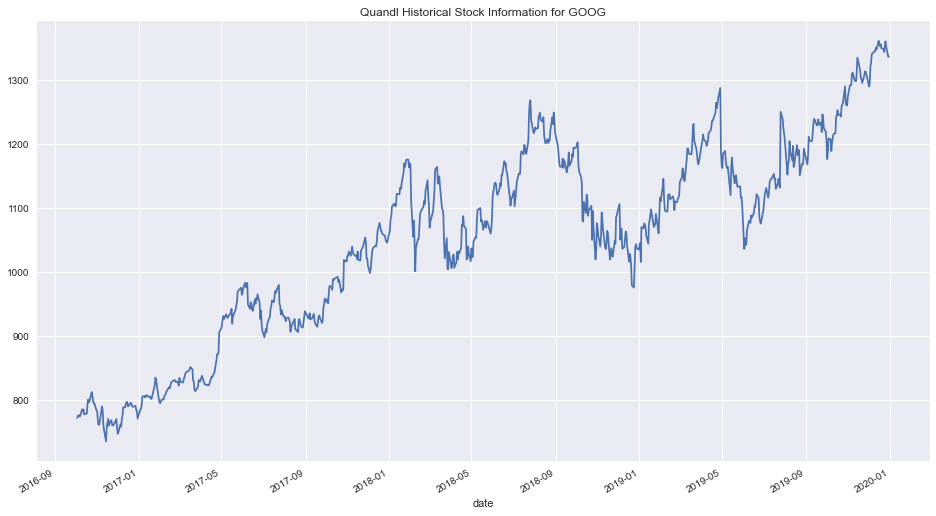

In [14]:
title_string = 'Quandl Historical Stock Information for ' + stock_symbol
stock_quandl['close'].plot(figsize=(16,9), title=title_string)
plt.show()

In [15]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3. Develop Strategy and Train Model

In [16]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Set up the Dataframe for the Trading Model

In [17]:
# Select the data source and pricing columns to use for modeling
# trading_model = stock_yahoo.loc[:, ['Open','Adj Close']]
# trading_model = stock_alpha.loc[:, ['open','adj_close']]
trading_model = stock_quandl.loc[:, ['open','close']]
# trading_model = stock_quandl.loc[start_date:end_date, ['Adj_Close']]

# Set up the standard column name for modeling
trading_model.rename(columns={'open': 'open_price', 'close': 'close_price'}, inplace=True)
trading_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 817 entries, 2016-10-03 to 2019-12-31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   817 non-null    float64
 1   close_price  817 non-null    float64
dtypes: float64(2)
memory usage: 19.1 KB


In [18]:
trading_model.head()

,open_price,close_price
date,,
2016-10-03,774.25,772.56
2016-10-04,776.03,776.43
2016-10-05,779.31,776.47
2016-10-06,779.00,776.86
2016-10-07,779.66,775.08


In [19]:
trading_model.tail()

,open_price,close_price
date,,
2019-12-24,1348.50,1343.56
2019-12-26,1346.17,1360.40
2019-12-27,1362.99,1351.89
2019-12-30,1350.00,1336.14
2019-12-31,1330.11,1337.02


### 3.b) Set up the Analysis Table with Indicators

In [20]:
def trading_ma_crossover(data):
    wait_for_entry = True
    for x in range(len(data)):
        if data['ma_change'].iloc[x] > 0:
            data['position'].iloc[x] = 1  # Position = 1 means we should take a long position
        else:
            data['position'].iloc[x] = 0  # Position = 0 means we should take a flat or a short position
        if x != 0:
            data['signal_change'].iloc[x] = data['position'].iloc[x] - data['position'].iloc[x-1]
            if wait_for_entry and (data['signal_change'].iloc[x-1] == 1):
                data['entry_exit'].iloc[x] = data['signal_change'].iloc[x-1]
                wait_for_entry = False
            elif (not wait_for_entry) and (data['signal_change'].iloc[x-1] != 0):
                data['entry_exit'].iloc[x] = data['signal_change'].iloc[x-1]

In [21]:
trading_model['fast_ma'] = trading_model['close_price'].ewm(span=fast_ma).mean()
trading_model['slow_ma'] = trading_model['close_price'].ewm(span=slow_ma).mean()
trading_model['ma_change'] = trading_model['fast_ma'] - trading_model['slow_ma']
trading_model['position'] = np.zeros(len(trading_model))
trading_model['signal_change'] = np.zeros(len(trading_model))
trading_model['entry_exit'] = np.zeros(len(trading_model))
trading_model = trading_model[model_start_date:model_end_date]
trading_model.head()

,open_price,close_price,fast_ma,slow_ma,ma_change,position,signal_change,entry_exit
date,,,,,,,,
2017-01-03,778.81,786.14,783.713508,780.198236,3.515272,0.0,0.0,0.0
2017-01-04,788.36,786.90,784.017438,780.482129,3.535309,0.0,0.0,0.0
2017-01-05,786.08,794.02,784.971353,781.053807,3.917546,0.0,0.0,0.0
2017-01-06,795.26,806.15,786.990839,782.110388,4.880451,0.0,0.0,0.0
2017-01-09,806.40,806.65,788.865216,783.140564,5.724652,0.0,0.0,0.0


In [22]:
trading_model.tail()

,open_price,close_price,fast_ma,slow_ma,ma_change,position,signal_change,entry_exit
date,,,,,,,,
2019-12-24,1348.50,1343.56,1336.844510,1304.858965,31.985545,0.0,0.0,0.0
2019-12-26,1346.17,1360.40,1339.087890,1307.037045,32.050845,0.0,0.0,0.0
2019-12-27,1362.99,1351.89,1340.307138,1308.795984,31.511154,0.0,0.0,0.0
2019-12-30,1350.00,1336.14,1339.910268,1309.868298,30.041970,0.0,0.0,0.0
2019-12-31,1330.11,1337.02,1339.635004,1310.933071,28.701933,0.0,0.0,0.0


In [23]:
trading_ma_crossover(trading_model)

# List the Buy signals
trading_model[(trading_model.signal_change != 0) | (trading_model.entry_exit != 0)]

,open_price,close_price,fast_ma,slow_ma,ma_change,position,signal_change,entry_exit
date,,,,,,,,
2017-08-10,917.55,907.24,934.111752,934.258908,-0.147156,0.0,-1.0,0.0
2017-09-28,941.36,949.50,930.140646,929.313454,0.827191,1.0,1.0,0.0
2017-09-29,952.00,959.11,932.899632,930.481997,2.417635,1.0,0.0,1.0
2018-03-26,1046.00,1053.21,1096.283670,1096.303976,-0.020306,0.0,-1.0,0.0
2018-03-27,1063.00,1005.10,1087.599511,1092.727348,-5.127838,0.0,0.0,-1.0
2018-05-15,1090.00,1079.23,1061.882313,1061.699535,0.182778,1.0,1.0,0.0
2018-05-16,1077.31,1081.77,1063.776378,1062.486612,1.289767,1.0,0.0,1.0
2018-09-18,1157.09,1161.22,1187.196546,1188.622871,-1.426325,0.0,-1.0,0.0
2018-09-19,1164.98,1171.09,1185.662589,1187.935307,-2.272718,0.0,0.0,-1.0


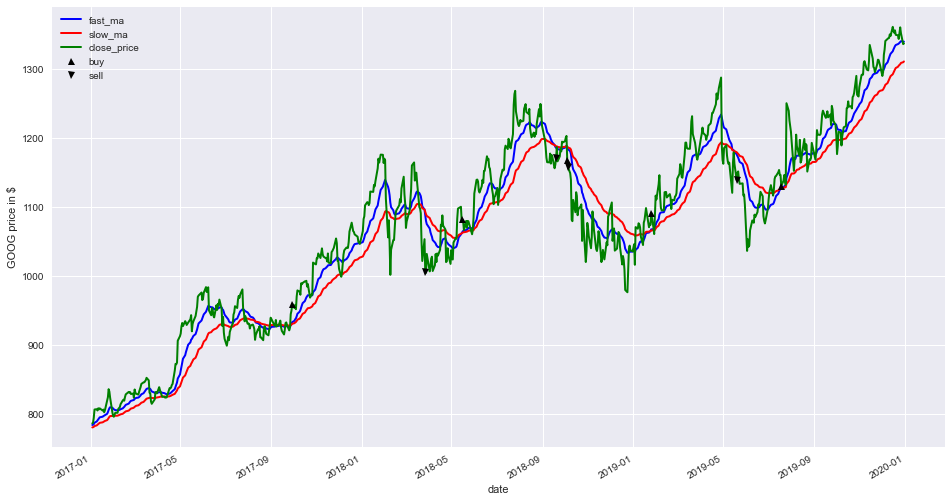

In [24]:
graph_data = trading_model[:]
fig = plt.figure(figsize=(16,9))
ylabel = stock_symbol + ' price in $'
ax1 = fig.add_subplot(111, ylabel=ylabel)
graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
graph_data['close_price'].plot(ax=ax1, color='g', lw=2.)
ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
plt.legend()
plt.show()

In [25]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4. Back-test Model

In [26]:
if notifyStatus: email_notify("Task 4. Back-test Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [27]:
# Construct a portfolio to track the transactions and returns
portfolio = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction',
                                                             'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
portfolio.iloc[0]['trade_action'] = 0
portfolio.iloc[0]['qty_onhand'] = 0
portfolio.iloc[0]['cost_basis'] = 0.00
portfolio.iloc[0]['sold_transaction'] = 0.00
portfolio.iloc[0]['gain_loss'] = 0.00
portfolio.iloc[0]['cash_onhand'] = initial_capital
portfolio.iloc[0]['position_value'] = 0.00
portfolio.iloc[0]['total_position'] = initial_capital
portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_capital
recent_cost = 0

# The conditional parameters below determine how the trading strategy will be carried out
for i in range(1, len(portfolio)):
    if (trading_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
        portfolio.iloc[i]['trade_action'] = 1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cost_basis'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['gain_loss'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
        recent_cost = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
        print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
    elif (trading_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
        portfolio.iloc[i]['trade_action'] = -1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cost_basis'] = 0.00
        portfolio.iloc[i]['sold_transaction'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
        portfolio.iloc[i]['gain_loss'] = (recent_cost + (trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
        recent_cost = 0.00
        print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
    else:
        portfolio.iloc[i]['trade_action'] = 0
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
        portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['gain_loss'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
    portfolio.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
    portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
    portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_capital

BOUGHT QTY: 1 on 2017-09-29 00:00:00 at the price of 952.0
SOLD QTY: -1 on 2018-03-27 00:00:00 at the price of 1063.0
BOUGHT QTY: 1 on 2018-05-16 00:00:00 at the price of 1077.31
SOLD QTY: -1 on 2018-09-19 00:00:00 at the price of 1164.98
BOUGHT QTY: 1 on 2018-10-04 00:00:00 at the price of 1195.33
SOLD QTY: -1 on 2018-10-05 00:00:00 at the price of 1167.5
BOUGHT QTY: 1 on 2019-01-25 00:00:00 at the price of 1085.0
SOLD QTY: -1 on 2019-05-20 00:00:00 at the price of 1144.5
BOUGHT QTY: 1 on 2019-07-19 00:00:00 at the price of 1148.19


In [28]:
portfolio[portfolio.trade_action == 1]

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
date,,,,,,,,,
2017-09-29,1,1,952,0,0,548,959.11,1507.11,7.11
2018-05-16,1,1,1077.31,0,0,533.69,1081.77,1615.46,115.46
2018-10-04,1,1,1195.33,0,0,503.34,1168.19,1671.53,171.53
2019-01-25,1,1,1085,0,0,585.84,1090.99,1676.83,176.83
2019-07-19,1,1,1148.19,0,0,582.15,1130.1,1712.25,212.25


In [29]:
portfolio[portfolio.trade_action == -1]

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
date,,,,,,,,,
2018-03-27,-1,0,0,1063,111,1611,0,1611,111
2018-09-19,-1,0,0,1164.98,87.67,1698.67,0,1698.67,198.67
2018-10-05,-1,0,0,1167.5,-27.83,1670.84,0,1670.84,170.84
2019-05-20,-1,0,0,1144.5,59.5,1730.34,0,1730.34,230.34


In [30]:
portfolio.head(20)

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
date,,,,,,,,,
2017-01-03,0,0,0,0,0,1500,0,1500,0
2017-01-04,0,0,0,0,0,1500,0,1500,0
2017-01-05,0,0,0,0,0,1500,0,1500,0
2017-01-06,0,0,0,0,0,1500,0,1500,0
2017-01-09,0,0,0,0,0,1500,0,1500,0
2017-01-10,0,0,0,0,0,1500,0,1500,0
2017-01-11,0,0,0,0,0,1500,0,1500,0
2017-01-12,0,0,0,0,0,1500,0,1500,0
2017-01-13,0,0,0,0,0,1500,0,1500,0


In [31]:
portfolio.tail(20)

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
date,,,,,,,,,
2019-12-03,0,1,1148.19,0,0,582.15,1295.28,1877.43,377.43
2019-12-04,0,1,1148.19,0,0,582.15,1320.54,1902.69,402.69
2019-12-05,0,1,1148.19,0,0,582.15,1328.13,1910.28,410.28
2019-12-06,0,1,1148.19,0,0,582.15,1340.62,1922.77,422.77
2019-12-09,0,1,1148.19,0,0,582.15,1343.56,1925.71,425.71
2019-12-10,0,1,1148.19,0,0,582.15,1344.66,1926.81,426.81
2019-12-11,0,1,1148.19,0,0,582.15,1345.02,1927.17,427.17
2019-12-12,0,1,1148.19,0,0,582.15,1350.27,1932.42,432.42
2019-12-13,0,1,1148.19,0,0,582.15,1347.83,1929.98,429.98


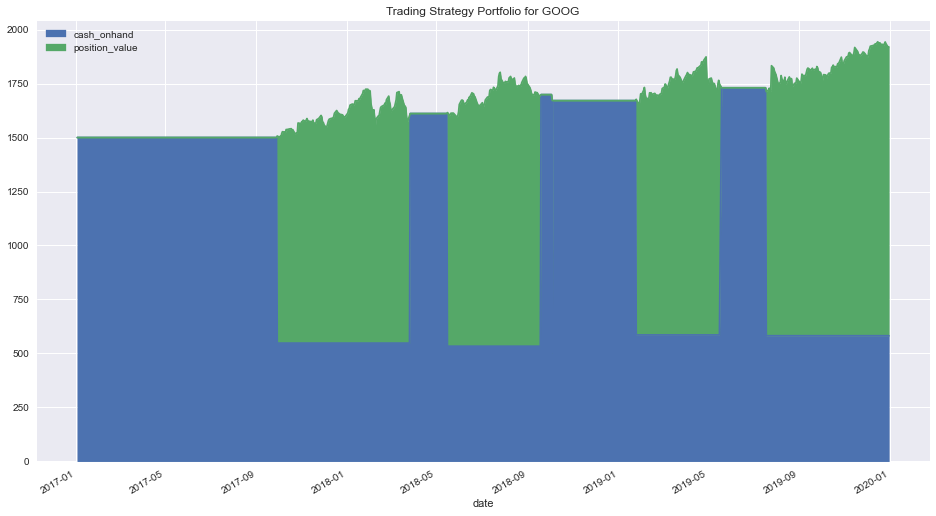

In [32]:
title_string = 'Trading Strategy Portfolio for ' + stock_symbol
portfolio[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [33]:
if notifyStatus: email_notify("Task 4. Back-test Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5. Evaluate Performance

In [34]:
if notifyStatus: email_notify("Task 5. Evaluate Performance has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [35]:
# Construct a long only as a benchmark for the trading strategy
benchmark = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cash_onhand', 'position_value', 'total_position', "accumu_return"])
benchmark.iloc[0]['trade_action'] = 1
benchmark.iloc[0]['qty_onhand'] = benchmark.iloc[0]['trade_action']
benchmark.iloc[0]['cash_onhand'] = initial_capital - (trading_model.iloc[0]['open_price'] * benchmark.iloc[0]['trade_action'])
benchmark.iloc[0]['position_value'] = trading_model.iloc[0]['open_price']
benchmark.iloc[0]['total_position'] = initial_capital
benchmark.iloc[0]['accumu_return'] = benchmark.iloc[0]['total_position'] - initial_capital

for i in range(1, len(portfolio)):
    benchmark.iloc[i]['trade_action'] = 0
    benchmark.iloc[i]['qty_onhand'] = benchmark.iloc[i-1]['qty_onhand']
    benchmark.iloc[i]['cash_onhand'] = benchmark.iloc[i-1]['cash_onhand']
    benchmark.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * benchmark.iloc[i]['qty_onhand']
    benchmark.iloc[i]['total_position'] = benchmark.iloc[i]['cash_onhand'] + benchmark.iloc[i]['position_value']
    benchmark.iloc[i]['accumu_return'] = benchmark.iloc[i]['total_position'] - initial_capital

benchmark.head(10)

,trade_action,qty_onhand,cash_onhand,position_value,total_position,accumu_return
date,,,,,,
2017-01-03,1,1,721.19,778.81,1500,0
2017-01-04,0,1,721.19,786.9,1508.09,8.09
2017-01-05,0,1,721.19,794.02,1515.21,15.21
2017-01-06,0,1,721.19,806.15,1527.34,27.34
2017-01-09,0,1,721.19,806.65,1527.84,27.84
2017-01-10,0,1,721.19,804.79,1525.98,25.98
2017-01-11,0,1,721.19,807.91,1529.1,29.1
2017-01-12,0,1,721.19,806.36,1527.55,27.55
2017-01-13,0,1,721.19,807.88,1529.07,29.07


In [36]:
benchmark.tail(10)

,trade_action,qty_onhand,cash_onhand,position_value,total_position,accumu_return
date,,,,,,
2019-12-17,0,1,721.19,1355.12,2076.31,576.31
2019-12-18,0,1,721.19,1352.62,2073.81,573.81
2019-12-19,0,1,721.19,1356.04,2077.23,577.23
2019-12-20,0,1,721.19,1349.59,2070.78,570.78
2019-12-23,0,1,721.19,1348.84,2070.03,570.03
2019-12-24,0,1,721.19,1343.56,2064.75,564.75
2019-12-26,0,1,721.19,1360.4,2081.59,581.59
2019-12-27,0,1,721.19,1351.89,2073.08,573.08
2019-12-30,0,1,721.19,1336.14,2057.33,557.33


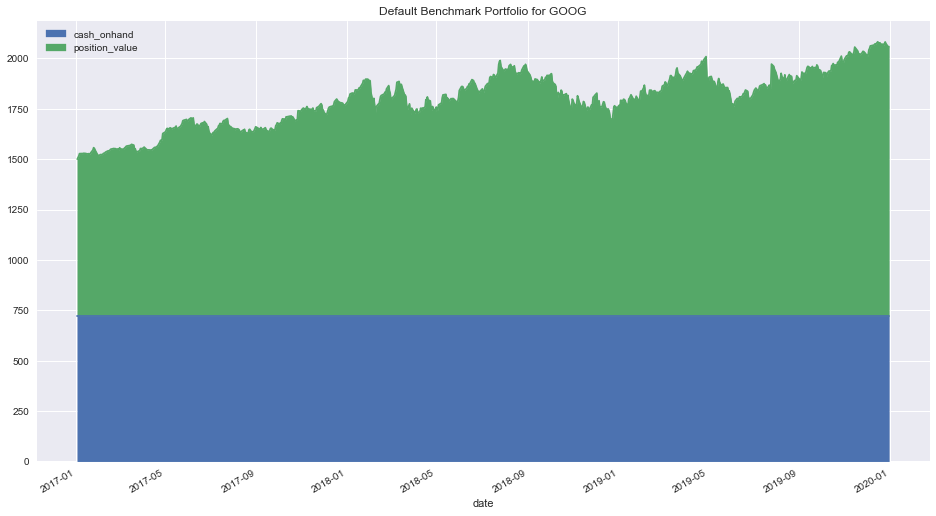

In [37]:
title_string = 'Default Benchmark Portfolio for ' + stock_symbol
benchmark[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [38]:
# Build a performance data frame to display the returns from the strategy and benchmark
performance = pd.DataFrame(index=trading_model.index)
performance['strategy'] = portfolio['accumu_return']
performance['benchmark'] = benchmark['accumu_return']

performance.tail(10)

,strategy,benchmark
date,,
2019-12-17,437.27,576.31
2019-12-18,434.77,573.81
2019-12-19,438.19,577.23
2019-12-20,431.74,570.78
2019-12-23,430.99,570.03
2019-12-24,425.71,564.75
2019-12-26,442.55,581.59
2019-12-27,434.04,573.08
2019-12-30,418.29,557.33


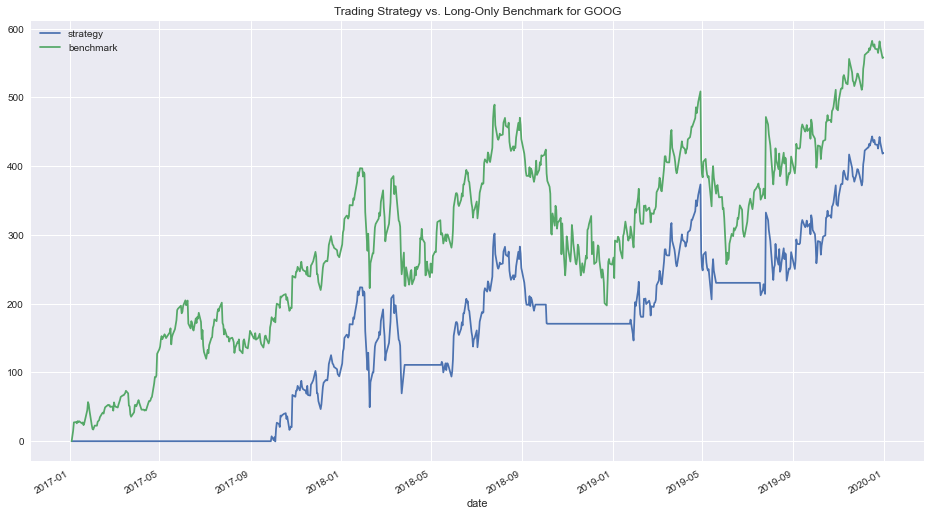

In [39]:
title_string = 'Trading Strategy vs. Long-Only Benchmark for ' + stock_symbol
performance[['strategy','benchmark']].plot(figsize=(16,9), title=title_string)
plt.show()

In [40]:
print('The accumulated return/loss from the trading strategy: %.2f percent' % (performance.iloc[-1]['strategy'] / initial_capital * 100))
print('The accumulated return/loss from the long-only benchmark: %.2f percent' % (performance.iloc[-1]['benchmark'] / initial_capital * 100))

The accumulated return/loss from the trading strategy: 27.94 percent
The accumulated return/loss from the long-only benchmark: 37.21 percent


In [41]:
if notifyStatus: email_notify("Task 5. Evaluate Performance completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [42]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:06.443593
